In [1]:
import numpy as np

def adam(fgrad, xinit, ferr=None, f=None, tol=1e-8, maxiters=1000,
         alpha=0.001, eps=1e-8, beta1=0.9, beta2=0.999):
    
    
    x = xinit

    # initial residual and norms
    if ferr:
        errs = [ferr(x)]

    if f:
        vals = [f(x)]

    # initial Adam state
    mom = np.zeros_like(x)  # first moment (m)
    var = np.zeros_like(x)  # second moment (v)

    for i in range(1, maxiters + 1):
        grad = fgrad(x)
        
        # Adam-style moments on the residual
        mom = beta1 * mom + (1.0 - beta1) * grad
        var = beta2 * var + (1.0 - beta2) * (grad * grad)

        # bias corrections
        mhat = mom / (1.0 - beta1**i)
        vhat = var / (1.0 - beta2**i)

        # parameter update
        x = x - alpha * (mhat / (np.sqrt(vhat) + eps))

        if f:
            vals.append(f(x))
        if ferr:
            err = ferr(x)
            errs.append(err)
            if err <= tol:
                break

    if ferr:
        if f:
            return x, vals, errs
        else:
            return x, errs
    else:
        if f:
            return x, vals
        else:
            return x

## Test problem:

Let's try the stochastic optimization problem
$$
\min_{x \in \mathbb{R}^n} E[f(x,\xi)]
$$
where
$$
f(x,\xi) = \Vert A(x + \xi) \Vert_2^2
$$
and $A = A^T$ is an $n \times n$ real-symmetric matrix, while $\xi \in \mathbb{R}^n$

The expectation value $E[\cdots]$ is for $\xi$ drawn from i.i.d. Gaussian random variables $\xi_k \sim N(0,1)$.

Analytically, the minimizer should simply be at $x = 0$.

Note that $\nabla_x f = 2A(x + \xi)$.

Our starting guess will simply be `x = randn(n)`, and we'll use $A = I$ to start with.

In [2]:
n = 100
xinit = np.ones(n)
xinit = np.random.randn(n)
A = np.eye(n,n)
noise = 0.01

xi = np.random.randn(n) * noise

def fgrad(x):
    global xi
    xi = np.random.randn(n) * noise
    return 2*(A.T @ A @ (x + xi))

def ferr(x):
    return np.linalg.norm(x)

def f(x):
    return np.linalg.norm(A*(x + xi))**2

x, vals, errs = adam(xinit=xinit, fgrad=fgrad, ferr=ferr, f=f, maxiters=10**4)

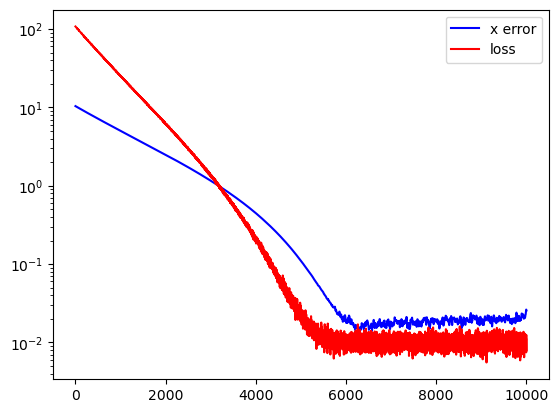

In [3]:
import matplotlib.pyplot as plt

plt.semilogy(errs, "b-")
plt.semilogy(vals, "r-")
plt.legend(["x error", "loss"])

In [4]:
import nlopt

opt = nlopt.opt(nlopt.LD_CCSAQ, n)

xi = np.random.randn(n)

evals = 0
f_evals = []
x_errs = []
f_vals = []

def f_and_grad(x, grad):
    global xi, evals, f_evals, x_errs
    if grad.size > 0:
        xi = np.random.randn(n) * noise
        grad[:] = 2*(A.T @ A @ (x + xi))
        evals = evals + 1
    else:
        evals = evals + 0.5 # no gradient is half the cost in theory
    val = np.linalg.norm(A @ (x+xi))**2
    if grad.size > 0: # only plot outer iterations
        f_evals.append(evals)
        x_errs.append(np.linalg.norm(x))
        f_vals.append(val)
    return val

opt.set_param("inner_gradients", 0)
opt.set_param("always_improve", 0)
opt.set_param("sigma_min", 0)
opt.set_min_objective(f_and_grad)
opt.set_maxeval(5000)
xopt = opt.optimize(xinit)
opt.last_optimize_result()

5

Text(0.5, 1.0, 'noise $\\xi_j \\sim N(0, 0.01)$, $A = I$ (condition # = 1)')

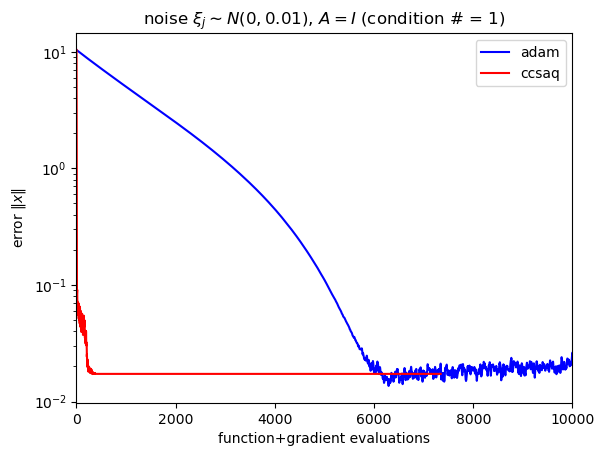

In [5]:
# Plotting the error

plt.semilogy(errs, "b-")
plt.semilogy(np.asarray(f_evals), x_errs, "r-")
plt.legend(["adam", "ccsaq"])
plt.xlabel("function+gradient evaluations")
plt.ylabel("error $\\Vert x \\Vert$")
plt.xlim(0, 10**4)
plt.title("noise $\\xi_j \\sim N(0, {noise})$, $A = I$ (condition # = 1)".format(noise=noise))

Text(0.5, 1.0, 'noise $\\xi_j \\sim N(0, 0.01)$, $A = I$ (condition # = 1)')

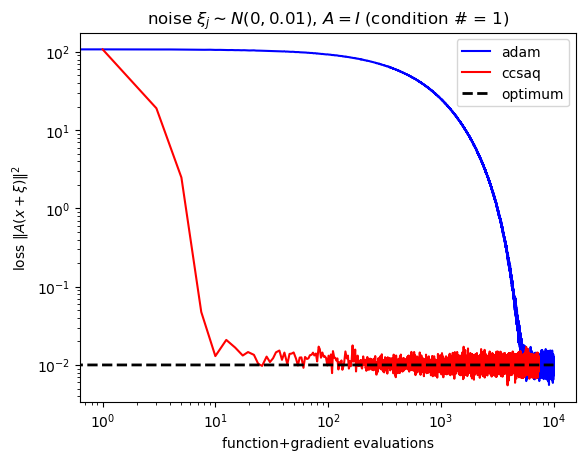

In [6]:
# Plotting the loss

plt.loglog(vals, "b-")
plt.loglog(np.asarray(f_evals), f_vals, "r-")
plt.loglog(np.ones(len(vals)) * np.linalg.norm(A, "fro")**2 * noise**2, "k--", linewidth=2)
plt.legend(["adam", "ccsaq", "optimum"])
plt.xlabel("function+gradient evaluations")
plt.ylabel("loss $\\Vert A(x+\\xi) \\Vert^2$")
plt.title("noise $\\xi_j \\sim N(0, {noise})$, $A = I$ (condition # = 1)".format(noise=noise))

In [24]:
# random nxn matrix with condition number κ and log-spaced singular values
def randcond(n, κ):
    Q, R = np.linalg.qr(np.random.randn(n, n))
    Q = Q @ np.diag(np.sign(np.diag(R))) # randomize signs
    σ = np.logspace(np.log10(1), np.log10(1/κ), num=n)
    return Q @ np.diag(σ) @ Q.T

In [25]:
np.linalg.cond(randcond(5, 100))

np.float64(99.9999999999998)

In [26]:
κ = 100
A = randcond(n, κ)

x, vals, errs = adam(xinit=xinit, fgrad=fgrad, ferr=ferr, f=f, maxiters=10**6)

NameError: name 'κ' is not defined

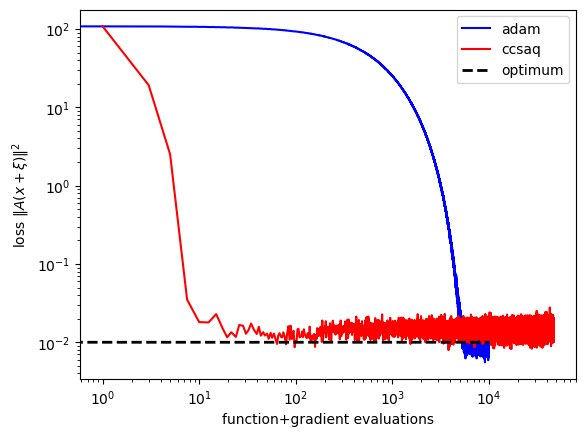

In [7]:
evals = 0
f_evals = []
x_errs = []
f_vals = []
opt.set_maxeval(50000)
opt.set_param("sigma_min", 0.01)
opt.set_xtol_abs(0.0)
xopt = opt.optimize(xinit)

f_evals_old = f_evals
x_errs_old = x_errs
f_vals_old = f_vals

plt.loglog(vals, "b-")
plt.loglog(np.asarray(f_evals_old), f_vals_old, "r-")
plt.loglog(np.ones(len(vals)) * np.linalg.norm(A, "fro")**2 * noise**2, "k--", linewidth=2)
plt.legend(["adam", "ccsaq", "optimum"])
plt.xlabel("function+gradient evaluations")
plt.ylabel("loss $\\Vert A(x+\\xi) \\Vert^2$")
plt.title("noise $\\xi_j \\sim N(0, {noise})$, condition # = {κ}".format(noise=noise, κ=κ))

Text(0.5, 1.0, 'noise $\\xi_j \\sim N(0, 0.01)$, condition # = 100')

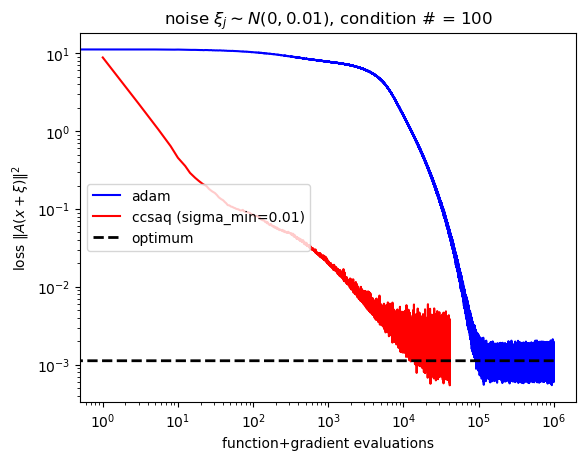

In [28]:
evals = 0
f_evals = []
x_errs = []
f_vals = []
opt.set_maxeval(50000)
sigma_min = 0.01
opt.set_param("sigma_min", sigma_min)
opt.set_xtol_abs(0.0)
xopt = opt.optimize(xinit)

f_evals_sigma_min = f_evals
x_errs_sigma_min = x_errs
f_vals_sigma_min = f_vals

plt.loglog(vals, "b-")
plt.loglog(np.asarray(f_evals_sigma_min), f_vals_sigma_min, "r-")
plt.loglog(np.ones(len(vals)) * np.linalg.norm(A, "fro")**2 * noise**2, "k--", linewidth=2)
plt.legend(["adam", "ccsaq (sigma_min={sigma_min})".format(sigma_min=sigma_min), "optimum"])
plt.xlabel("function+gradient evaluations")
plt.ylabel("loss $\\Vert A(x+\\xi) \\Vert^2$")
plt.title("noise $\\xi_j \\sim N(0, {noise})$, condition # = {κ}".format(noise=noise, κ=κ))

In [29]:
def foo(x):
    return np.linalg.norm(A @ (x+xi))**2, 2*(A.T @ A @ (x + xi))

f_evals = []
x_errs = []
f_vals = []

x = np.random.randn(n)
grad = np.zeros(n)
dx = np.random.randn(n) * 1e-8
val = f_and_grad(x, grad)
val2 = f_and_grad(x+dx, np.zeros(0))
val2 - val, np.dot(grad, dx)

(np.float64(6.999091084480824e-08), np.float64(6.999091005477902e-08))

Text(0.5, 1.0, 'noise $\\xi_j \\sim N(0, 0.01)$, condition # = 100')

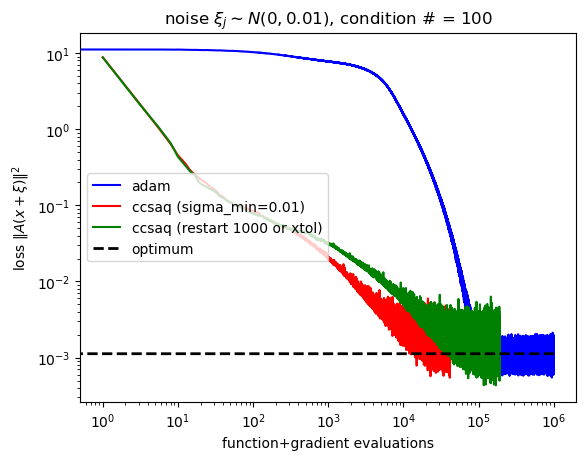

In [ ]:
evals = 0
f_evals = []
x_errs = []
f_vals = []
opt.set_maxeval(1000)
opt.set_xtol_abs(1e-3)
xopt = xinit
for i in range(1000):
    xopt = opt.optimize(xopt)

plt.loglog(vals, "b-")
plt.loglog(np.asarray(f_evals_sigma_min), f_vals_sigma_min, "r-")
plt.loglog(np.asarray(f_evals), f_vals, "g-")
plt.loglog(np.ones(len(vals)) * np.linalg.norm(A, "fro")**2 * noise**2, "k--", linewidth=2)
plt.legend(["adam", "ccsaq (sigma_min=0.01)", "ccsaq (restart 1000 or xtol)", "optimum"])
plt.xlabel("function+gradient evaluations")
plt.ylabel("loss $\\Vert A(x+\\xi) \\Vert^2$")
plt.title("noise $\\xi_j \\sim N(0, {noise})$, condition # = {κ}".format(noise=noise, κ=κ))